# QTQt time-temperature path output plotting

This Jupyter notebook is designed to take the raw time-temperature (t-T) output file from the QTQt thermal history modelling software of [Gallagher (2012)](https://doi.org/10.1029/2011JB008825) and replot the output as an image displaying t-T path density. So in these plots, relative probability is proportional to t--T path density, where darker colors (or higher saturation) denotes higher relative probability. Any t-T constraint boxes that were utilized during modelling can be plotted along with individual 'representative' model solutions (i.e., the maximum likehood or expected models).

**The example QTQt output file here (`QTQt2.txt`) is from Figure 3a in [McDannell and Issler (2021)](https://doi.org/10.5194/gchron-3-321-2021) but is too large to run in this demo due to memory usage. Download the Jupyter notebook and run locally for large files requiring >> memory. A smaller file `QTQt-Jupyter-demo.txt` is included for demonstration using the same 3 apatite fission-track kinetic populations in McDannell and Issler (2021).**

## Setup and explanation of how QTQt output is read in for plotting
The main QTQt output file needs to be in the same directory (i.e., output file that is "run-name.txt"), in this case the QTQt output file used for plotting input here is `QTQt-Jupyter-demo.txt`. The QTQt output file is arranged by row displaying: iteration #, likelihood value, posterior value, # of time-temperature points, and then the t-T pairs themselves. We use the `CHAIN` text in the output file as markers for the t-T blocks for the entire model run (this is the same thing that Kerry Gallagher uses in the QTQt software to grab plotting output). The `qtqt_print_step value` is either 2 or 3 based on whether the offset value between samples is used in QTQt. This number is shown as an additional between each t-T pair. Typically the `qtqt_print_step value` is '2' for a single data-type model run (i.e., modeling just an AFT sample) versus '3' for model runs with multiple types of data used as input (i.e., ZHe + AFT + AHe). In the example we have 3 separate fission track input files, so the step is `3`.Then we parse each row of t-T points into an array of arrays. Note these plots usually take a upwards of 2 to 3 minutes to be generated if the total model iterations is 10^6.

In [7]:
   ## --- Read QTQT output and plot as image

   using StatGeochem
   # Make sure we're running in the directory where the script is located
   cd(@__DIR__)

   #  Read data from file
   filenamebase = "QTQt-Jupyter-demo"
   ext = ".txt"
   qtqt_print_step = 3
   filepath = joinpath(@__DIR__, filenamebase*ext)
   lines = readlines(filepath)
   limits = findall(x->contains(x,"CHAIN"),lines)
   start, stop = limits[1]+1, limits[2]-1
   # Parse into array-of-arrays
   parsed = lines[start:stop] .|> x -> delim_string_parse(x, ' ', Float64)
    # # Alternative: parse into single 2d array
    # parsed = parsedlm(chain.captures[1], ' ', Float64)

10000-element Vector{Vector{Float64}}:
 [10001.0, -969.75005, -1080.273906, 9.0, 2000.131226, 300.389374, 0.0, 1970.40918, 237.255569, 0.0  …  0.0, 319.516327, 52.196648, 0.0, 229.747131, 31.34203, 0.0, 0.0, 6.957316, 3.237358]
 [10002.0, -969.75005, -1080.273906, 9.0, 2000.131226, 300.389374, 0.0, 1970.40918, 237.255569, 0.0  …  0.0, 319.516327, 52.196648, 0.0, 229.747131, 31.34203, 0.0, 0.0, 6.957316, 3.237358]
 [10003.0, -969.75005, -1080.273906, 9.0, 2000.131226, 300.389374, 0.0, 1970.40918, 237.255569, 0.0  …  0.0, 319.516327, 52.196648, 0.0, 229.747131, 31.34203, 0.0, 0.0, 6.957316, 3.237358]
 [10004.0, -969.75005, -1080.273906, 9.0, 2000.131226, 300.389374, 0.0, 1970.40918, 237.255569, 0.0  …  0.0, 319.516327, 52.196648, 0.0, 229.747131, 31.34203, 0.0, 0.0, 6.957316, 3.237358]
 [10005.0, -969.898099, -1091.529415, 10.0, 2000.131226, 300.389374, 0.0, 1970.40918, 237.255569, 0.0  …  0.0, 319.516327, 52.196648, 0.0, 229.747131, 31.34203, 0.0, 0.0, 6.957316, 3.237358]
 [10006.0, -96

In [8]:
    # Various one-color ramps for use, but most are now in StatGeochem also
    #color_x = [1.05; range(1.1,2,length=130); range(2+1/120,2.9,length=125)]
    #blues = linterp1(1:3, parse.(Color, ["#FFFFFF", "#0000FF", "#000000",]), color_x)
    #oranges = linterp1(1:3, parse.(Color, ["#FFFFFF", "#FF8f00", "#000000",]), color_x)
    #yellows = linterp1(1:3, parse.(Color, ["#FFFFFF", "#FFE900", "#000000",]), color_x)
    #greens = linterp1(1:3, parse.(Color, ["#FFFFFF", "#00AA66", "#000000",]), color_x)
    #cyans = linterp1(1:3, parse.(Color, ["#FFFFFF", "#00AAFF", "#000000",]), color_x)
    #reds = linterp1(1:3, parse.(Color, ["#FFFFFF", "#FF0000", "#000000",]), color_x)
    #violets = linterp1(1:3, parse.(Color, ["#FFFFFF", "#8000F0", "#000000",]), color_x)
    #purples = linterp1(1:3, parse.(Color, ["#FFFFFF", "#800080", "#000000",]), color_x)
    #magentas = linterp1(1:3, parse.(Color, ["#FFFFFF", "#F00080", "#000000",]), color_x)
    #export blues, oranges, yellows, greens, cyans, reds, violets, purples, magentas

## Plot image with a colormap showing t-T path density
Load the appropriate packages for plotting in Julia and the post burn-in stationary distribution is resized. This is then converted to an image using a color ramp of choice.

In [9]:
## --- Plot image with colormap

    using Plots
    using StatsBase: fit, Histogram
    using DelimitedFiles

    xresolution = 2000
    yresolution = 1000
    tmax = nanmaximum(parsed .|> x -> maximum(x[5:qtqt_print_step:end]))
    Tmax = nanmaximum(parsed .|> x -> maximum(x[6:qtqt_print_step:end]))

    # Resize the post-burnin part of the stationary distribution
    # the extrapolate value is for paths that 'begin' within the interior t-T space of the plot
    tTdist = Array{Float64}(undef, xresolution, length(parsed))
    xq = range(0,tmax,length=xresolution)
    for i=1:length(parsed)
        tTdist[:,i] = linterp1s(parsed[i][5:qtqt_print_step:end],parsed[i][6:qtqt_print_step:end],xq; extrapolate=-100)
    end

    # Calculate composite image
    tTimage = zeros(yresolution,size(tTdist,1))
    yq = range(0,Tmax,length=yresolution+1)
    for i=1:size(tTdist,1)
        tTimage[:,i] = fit(Histogram,tTdist[i,:],yq,closed=:right).weights
    end

*Note that log scaling of path (density) seems to work best for QTQt output where 'more complex' models are rejected, or the t-T bundle is very precisely constrained. Models where 'more complex' paths are allowed typically show some super-saturation if log scaling is set. Here we use log scaling of path density since this particular run had 'more complex' models rejected*

In [10]:
    tTimage = log.(tTimage .+ 1) #optional

1000×2000 Matrix{Float64}:
 0.0  0.0  0.0      2.48491  0.0      …  0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      2.48491     0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  1.09861  0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  2.30259  0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0  0.0  0.0      0.0      1.94591     0.0      0.0      0.0      0.0
 0.0  0.0  0.0      1.94591  0.0         0.0      0.0      0.0      0.0
 ⋮                                   

## Plotting the t-T image
replace `viridis` (navy/green/yellow) with `inferno` (black/red/yellow), `magma` (purple/red/yellow), or `water` works well with a blue monochromatic scheme. Any of the various one-color ramps shown above can also be called.

We set our default time and temperature axes for plotting to the `tmax` and `Tmax`, respectively, found in the QTQt output file. These values can be set to any value of your choosing. X and Y ascending or descending can be set with either `true` or `false`. Other plot features can be changed suited to your preferences.

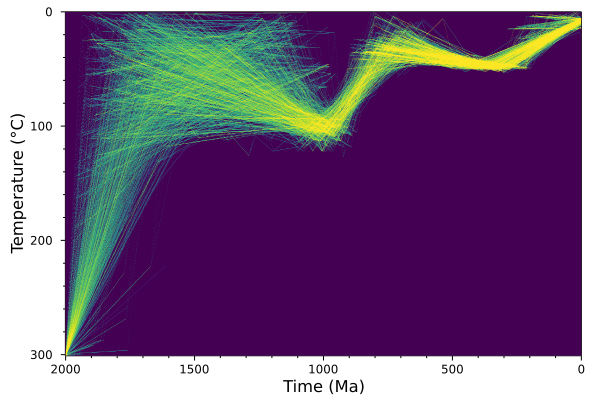

In [11]:
 A = imsc(tTimage,viridis,0,nanpctile(tTimage,98.5))
    h = plot(xlabel="Time (Ma)",ylabel="Temperature (°C)",yticks=0:100:Tmax,xticks=0:500:tmax,yminorticks=5,xminorticks=5,tick_dir=:out,framestyle=:box)
    plot!(h,xq,cntr(yq),A,yflip=true,xflip=true,legend=false,aspectratio=tmax/Tmax/1.5,xlims=(0,tmax),ylims=(0,Tmax))

## Overlays of constraint boxes or preferred model paths
Here we can overlay t-T boxes or the specific 'preferred' model t-T paths from QTQt, either the max. likelihood, max. posterior, expected ± 95% credible interval, or max. mode models (ML, MP, EX, MM). Here `EX` and `ML` are shown for simplicity and the former requires plotting of the mean path along with the +95% and -95% intervals (hence requiring 3 lines plotted), but the other paths are only a single set of t-T points (i.e., ML). The easiest way to get the QTQt ML, MP, etc. paths is either to view the output in QTQt and save the path to file or to find it in the output file manually. The `skipstart` function skips a set number of lines, in this case for `EX` it skips `4008` lines, which because this particular inversion had 3 separate input AFT files, there are 3 duplicated/identical `EX` paths-and we only need one of these sets for plotting. The `skipstart` value will need to be updated for any and all model runs.

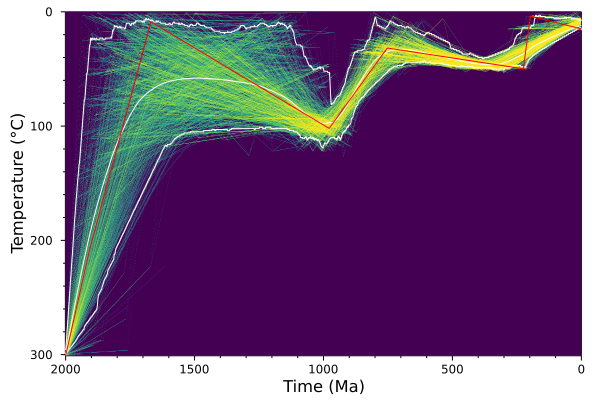

In [12]:
    # plot individual paths
    ########################
    EX = readdlm("EX1.txt",skipstart=4008)
    plot!(EX[:,1],EX[:,2],color=:white)
    plot!(EX[:,1],EX[:,3],color=:white)
    plot!(EX[:,1],EX[:,4],color=:white)

    ML = readdlm("ML1.txt",skipstart=22)
    plot!(ML[:,1],ML[:,2],color=:red)
    
    # t-T boxes, the first block is the time min/max and the second is the temp. min/max
    ########################
    #plot!([1600, 1700, 1700, 1600, 1600],[0, 0, 50, 50, 0], color=:white)#label="Proterozoic unconf.")
    #plot!([500, 540, 540, 500, 500],[0, 0, 40, 40, 0], color=:white)#label="sub-Cambrian unconf.")

    savefig(h,"$filenamebase.pdf")
    display(h)

## --- End of File